In [1]:
%matplotlib inline

import math
import numpy as np
import cmdstanpy
import pandas as pd
import arviz as az
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from scipy import stats

# Fetch the latest data on the epidemic

In [2]:
curl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
durl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
rurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

confirmed = pd.read_csv(curl, error_bad_lines=False)
dead = pd.read_csv(durl, error_bad_lines=False)
recovered = pd.read_csv(rurl, error_bad_lines=False)

Let's check out some of the earliest data sets.

In [3]:
def subset_country_names(table, countries):
    rose = []
    for country in countries:
        rose.append(confirmed[confirmed['Country/Region'] == country])
    return pd.concat(rose, axis=0)

subset_country_names(confirmed, ['Italy', 'Spain', 'Korea, South', 'France', 'Iran', 'Australia'])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
16,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980
18,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,500,673,1073,1695,2277,2277,5232,6391,7798,9942
156,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,7041,7314,7478,7513,7755,7869,7979,8086,8162,8236
157,France,France,46.2276,2.2137,0,0,2,3,3,3,...,949,1126,1209,1784,2281,2281,3661,4469,4499,6633
198,St Martin,France,18.0708,-63.0501,0,0,0,0,0,0,...,0,0,2,2,2,2,2,2,2,2
205,Saint Barthelemy,France,17.9000,-62.8333,0,0,0,0,0,0,...,3,3,1,1,1,1,1,1,1,3
406,French Polynesia,France,-17.6797,149.4068,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,3,3
436,French Guiana,France,3.9339,-53.1258,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,7,5
444,Mayotte,France,-12.8275,45.1662,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
449,Guadeloupe,France,16.2500,-61.5833,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


# Modelling one country at a time

## Extracting the time-series values

Here we'll pull out just the measurements we have for the specified country and organize them as a single matrix to feed into Stan.

We want to pull out observations starting after all the metadata stuff.

For ease of modelling, we automatically drop any lead-up period in which the subset of data to be analyzed had too few infections to be modelled accurately (this period varies depending on the country you select).  This may change if the model is able to take into account underreporting due to lack of testing; for now, it just means we won't have to account for a long period with no change by inflating measurement noise and increasing parameter uncertainty.

In [27]:
data_start_index = '1/22/20'

start_at_infections = 50
start_at_deaths = 5

# data_stop_index = -1

# worldometer.com, just took the current ones.  these numbers can be pretty approximate.
populations = {
    'Italy':60488135,
    'China':1435000000,
    'Korea, South':51256309,
    'Spain':46749498,
    'US':331002651,
    'Australia':25411689,
    'Iran':83671720,
    'France':65231249,
}

def extract_measurements(table, name):
    # Match out the row for the country, get rid of the initial metadata columns
    # and drop any leading or trailing NaN values
    return table.loc[table['Country/Region'] == name].loc[:, data_start_index:].dropna(axis=1).sum(axis=0)

def reached_n_infections(meas, n):
    return int(max(0, meas.shape[0] - meas.loc[meas['Confirmed'] > n - 1, :].shape[0])), 'Confirmed', n

def reached_n_deaths(meas, n):
    return int(max(0, meas.shape[0] - meas.loc[meas['Dead'] > n - 1, :].shape[0])), 'Dead', n

def truncate_initial(meas):
    confirmedt0 = reached_n_infections(meas, start_at_infections)
    deatht0 = reached_n_deaths(meas, start_at_deaths)
    return min(confirmedt0, deatht0, key=lambda x: x[0])

def form_table(name):
    c0 = extract_measurements(confirmed, name)
    r0 = extract_measurements(recovered, name)
    d0 = extract_measurements(dead, name)
    data = pd.concat([c0, r0, d0], axis=1)
    data.columns = ['Confirmed', 'Recovered', 'Dead']
    newt0, reason, limit = truncate_initial(data)
    print(f'{name} reached {limit} "{reason}" on {data.index[newt0]}; dropping preceding data')
    return data.iloc[newt0:, :]

In [28]:
country = 'US'

In [29]:
measurements = form_table(country)
day_count = measurements.shape[0]

US reached 50 "Confirmed" on 2/24/20; dropping preceding data


It's always a good idea to take a look at the data we plan to fit to.

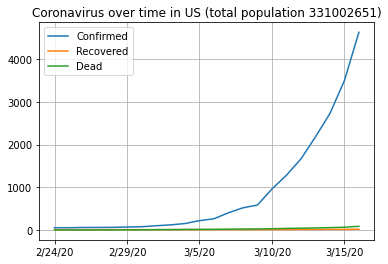

In [30]:
def display_measurements(measurements, name):
    title=f'Coronavirus over time in {name} (total population {populations[name]})'
    measurements.plot(grid=True,
                      title=title)
    
display_measurements(measurements, country)

If you plot an early country, you can clearly see the inflection point at which the behavior change caused an inflection point in infections.

## MCMC sampling

The first step is to arrange the data plus a bit of metadata information for the model so that we can pass it to Stan.

In [31]:
fit_data = {
    'y':measurements.to_numpy(),
    'T':day_count,
    'ts':list(range(0, day_count)),
    'population':populations[country],
    'sigma_infected_prior':[2, 0.5],
    'sigma_dead_prior':[2, 0.5],
    'beta_prior':[2.2, 0.15],
    'gamma_prior':[0, 0.1],
    'zeta_prior':[0, 0.1],
    'noise_skew':-5e-3,
}

Now kick off the sampler.  Note the options commented below.

In [32]:
model = cmdstanpy.CmdStanModel(stan_file='sird_reduced.stan')

fit = model.sample(data=fit_data, output_dir='.',
                   # Use a fixed seed so that our runs are deterministic.
                   seed=2222,
                   # This computer has 8 processors, 6 chains is fine
                   chains=6,
                   # Make the sampler a bit more robust in exchange for more sampling time
                   # adapt_delta=0.9,
                   # Let the sampler explore deeper
                   # max_treedepth=12,
                   # Make sure to get enough samples to avoid any diagnostic problems
                   iter_sampling=400)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_reduced
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 5
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 6


### Check the run

We'll pull up a few initial diagnostics.  If any warnings show up here, we should probably change the run parameters and resample.

In [33]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-1.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-2.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-3.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-4.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-5.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-6.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-1.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-2.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-3.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-4.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-5.csv, /home/peddie/programming/covid19-modelling/sird_reduced-202003171733-6.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [34]:
important_values = (
    'lp__',
    'beta',
    'gamma',
    'zeta',
    'sigma_infected',
    'sigma_dead',
) 
fit.summary().loc[important_values, :]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-187.984000,0.055775,1.712500,-191.442000,-187.601000,-185.976000,942.721,426.319,1.000840
beta,0.199048,0.000123,0.005035,0.190861,0.198976,0.207407,1689.310,763.942,1.000370
gamma,0.000728,0.000003,0.000139,0.000522,0.000716,0.000970,2440.290,1103.550,1.000790
zeta,0.006010,0.000011,0.000470,0.005294,0.005993,0.006828,1840.950,832.519,0.999847
sigma_infected,0.387054,0.001583,0.069433,0.293305,0.377233,0.510202,1923.230,869.727,0.999413
sigma_dead,0.247825,0.000575,0.028522,0.206301,0.245051,0.299738,2464.540,1114.520,0.999983


## Visualizing the posterior (a more meaningful posterior predictive check)

First we would like to be able to pull out the time series data from the MCMC results.

In [35]:
def get_sample_time_series(fit):
    yhat_indices = tuple([x.startswith('y_hat') for x in fit.column_names])
    yhat_samples = fit.sample[:, :, yhat_indices]
    assert(yhat_samples.shape[2] == day_count * 3)
    yhat_samples = yhat_samples.reshape((yhat_samples.shape[0] * yhat_samples.shape[1], 3, day_count))

    return yhat_samples

Next we will plot the time series observations overlaid on the posterior distribution from our MCMC analysis.

In [36]:
def plot_dist_time_series_std(axis, days, obs, samples, label):
    sample_mean = np.mean(samples, axis=0)
    sample_std = np.std(samples, axis=0)

    axis.fill_between(days,
                      means - 3 * stddevs, means + 3 * stddevs,
                      label=f'{label} 3-σ', color='#f0e0e0')
    axis.fill_between(days,
                      means - stddevs, means + stddevs,
                      label=f'{label} 1-σ', color='#e0d0d0')
    axis.plot(days, means,
              label=f'{label} mean')
    axis.plot(days, obs,
              label=f'Recorded {label}',
              marker='D', linewidth=0.8)
    plt.setp(axis.get_xticklabels(), visible=False)

    axis.grid(True)
    axis.set_ylabel(f'Number of {label} cases')
    axis.legend()

def plot_dist_time_series(axis, days, obs, samples, label, subsample=3):
    for sample in samples[0:-1:subsample, :]:
        axis.plot(days,
                  sample,
                  linewidth=0.05, color='blue', alpha=0.5)
    axis.plot(days,
              samples[-1, :],
              linewidth=0.05, color='blue', alpha=0.5, 
              label=f'MCMC draws (subsampled by {subsample})')
    axis.plot(days, np.mean(samples, axis=0),
              label=f'{label} mean', color='red')
    axis.plot(days, obs,
             label=f'Recorded {label}',
             marker='D', linewidth=0.8)

    axis.grid(True)
    axis.set_ylabel(f'Number of {label} cases')
    axis.legend()
        
def plot_posterior_time_series(samples, meas, name, plotf=plot_dist_time_series):
    days = samples.shape[2]
    
    fig = plt.figure(figsize=(15, 10))
    fig.set_tight_layout(True)
    gs = gridspec.GridSpec(3, 1)
    fig.suptitle(f'Coronavirus epidemic in {name} from {meas.index[0]} to {meas.index[-1]}')
    
    # Pull out the last axis now so that we can link x-axes (this only matters in interactive plots)
    last_axis = plt.subplot(gs[-1])
    labels = ['Confirmed', 'Recovered', 'Dead']
    for axis_idx in range(3):
        not_last = axis_idx != len(labels) - 1
        axis = plt.subplot(gs[axis_idx], sharex=last_axis) if not_last else last_axis
        plotf(axis, pd.to_datetime(meas.index),
              meas.to_numpy()[:, axis_idx],
              samples[:, axis_idx, :],
              labels[axis_idx])
        if not_last:
            plt.setp(axis.get_xticklabels(), visible=False)

    # Last axis is special for label-handling purposes
    last_axis.set_xlabel(f'Date')
    for tick in last_axis.get_xticklabels():
        tick.set_rotation(22)

    plt.tight_layout()
    plt.show()

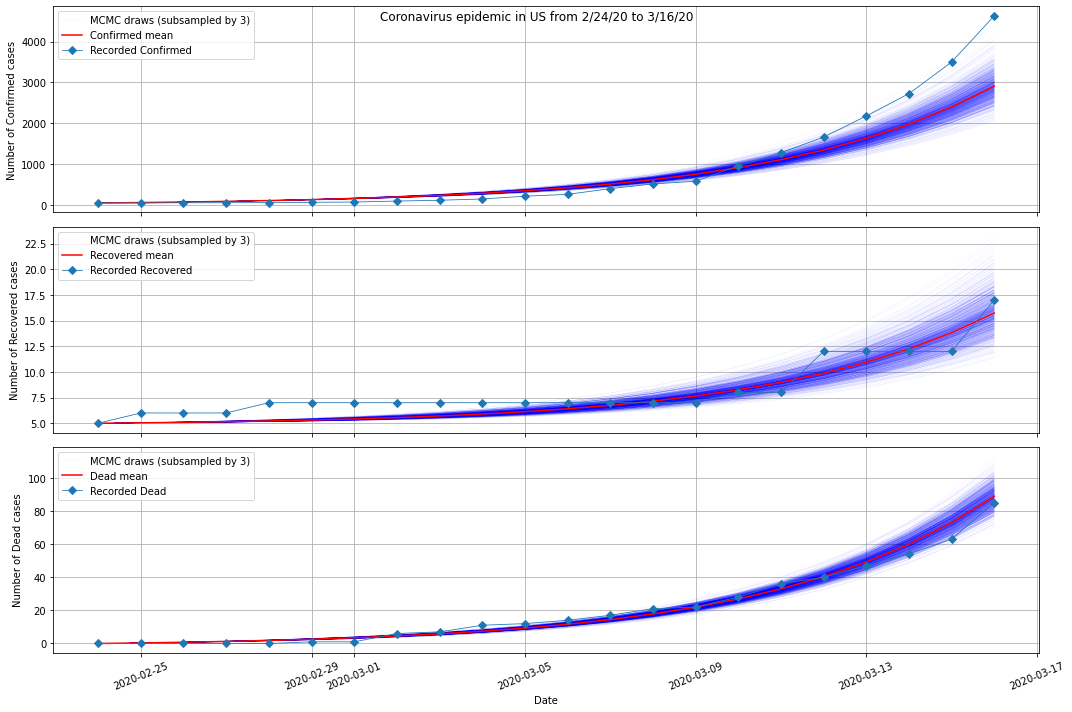

In [37]:
yhat_samples = get_sample_time_series(fit)
plot_posterior_time_series(yhat_samples, measurements, country)

### Error / likelihood analyses

We can look at the likelihood of the final data given the posterior distribution of parameters and the RMS error between our modelled mean value and the observations.

In [38]:
def data_likelihood_from_fit(fit):
    results = fit.get_drawset()
    indices = tuple([x for x in fit.column_names if x.startswith('log_likelihood')])
    results.loc[:, indices].sum(axis=1)

# TODO(MP): understand this
data_likelihood_from_fit(fit)

## Extended diagnostics

We'll use arviz to do some more diagnostic plots.

In [39]:
inferred = az.from_cmdstanpy(fit, 
                             log_likelihood='log_likelihood',
                             posterior_predictive='y_hat',
                             observed_data={'y':measurements.to_numpy()})

# TODO(MP): how do you plot log probability of the sample?  'lp__' is gone.
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))

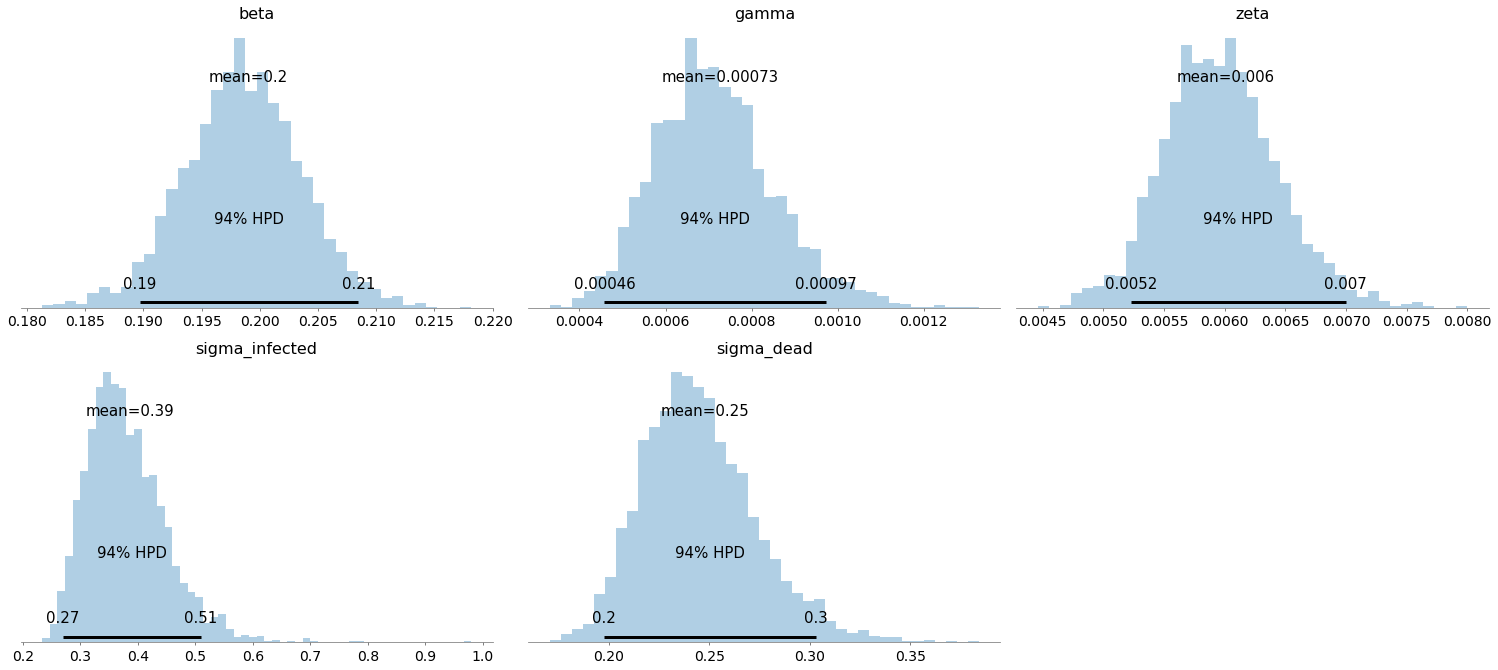

In [40]:
_ = az.plot_posterior(inferred, var_names=analysis_variables, kind='hist')

### Posterior correlation plots

What is going on with gamma and beta?

/home/peddie/.local/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


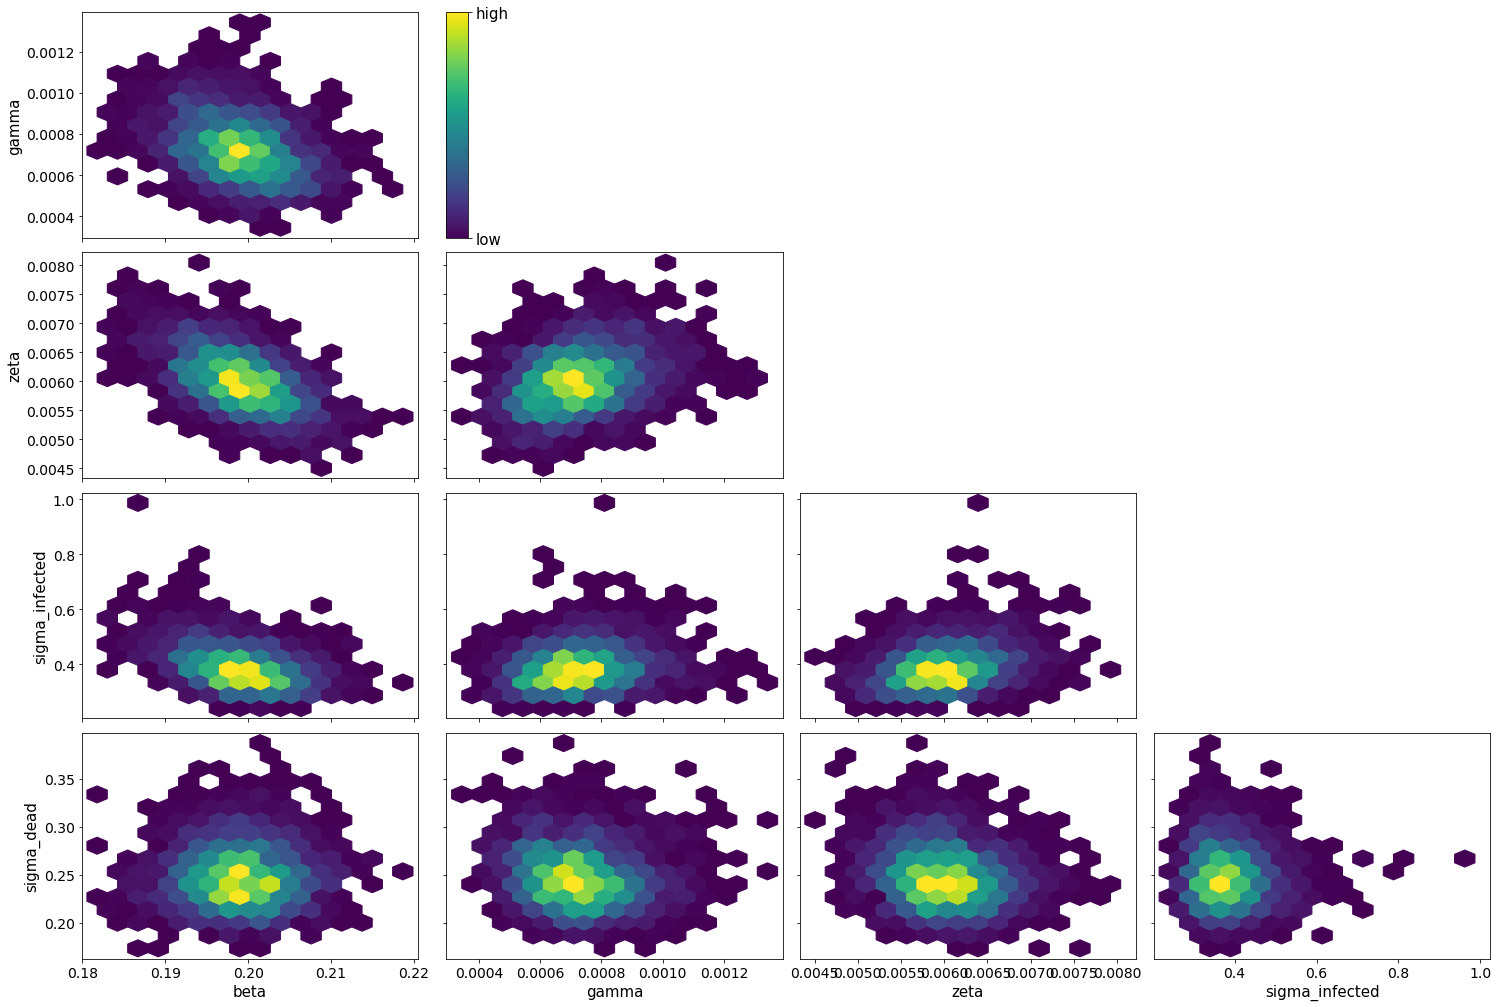

In [41]:
_ = az.plot_pair(inferred, var_names=analysis_variables,
                 kind='hexbin', colorbar=True, divergences=True)

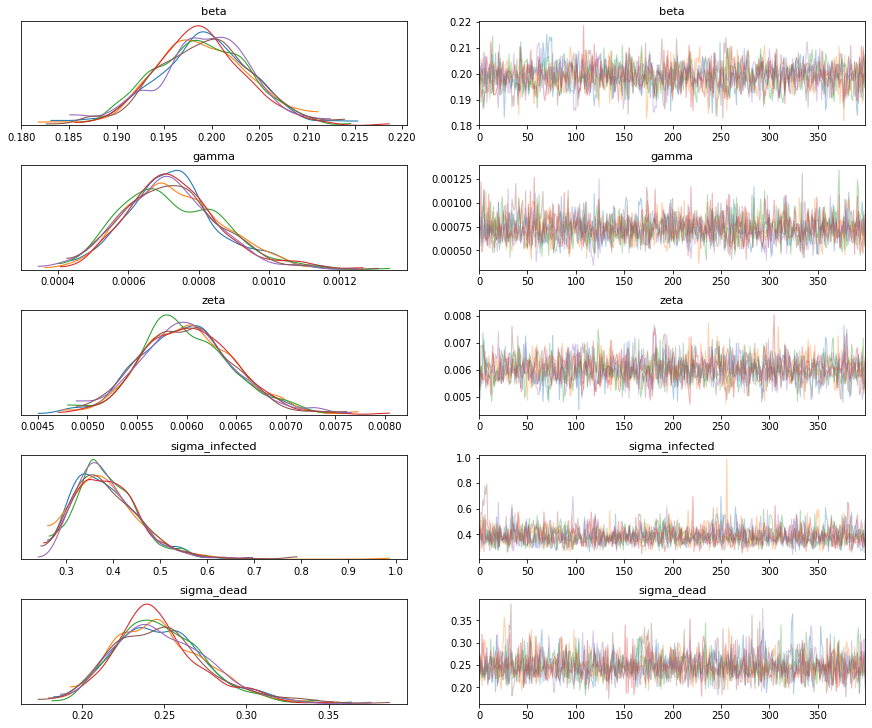

In [42]:
_ = az.plot_trace(inferred, var_names=analysis_variables)

### Effective sample size

We don't have any low effective sample sizes.

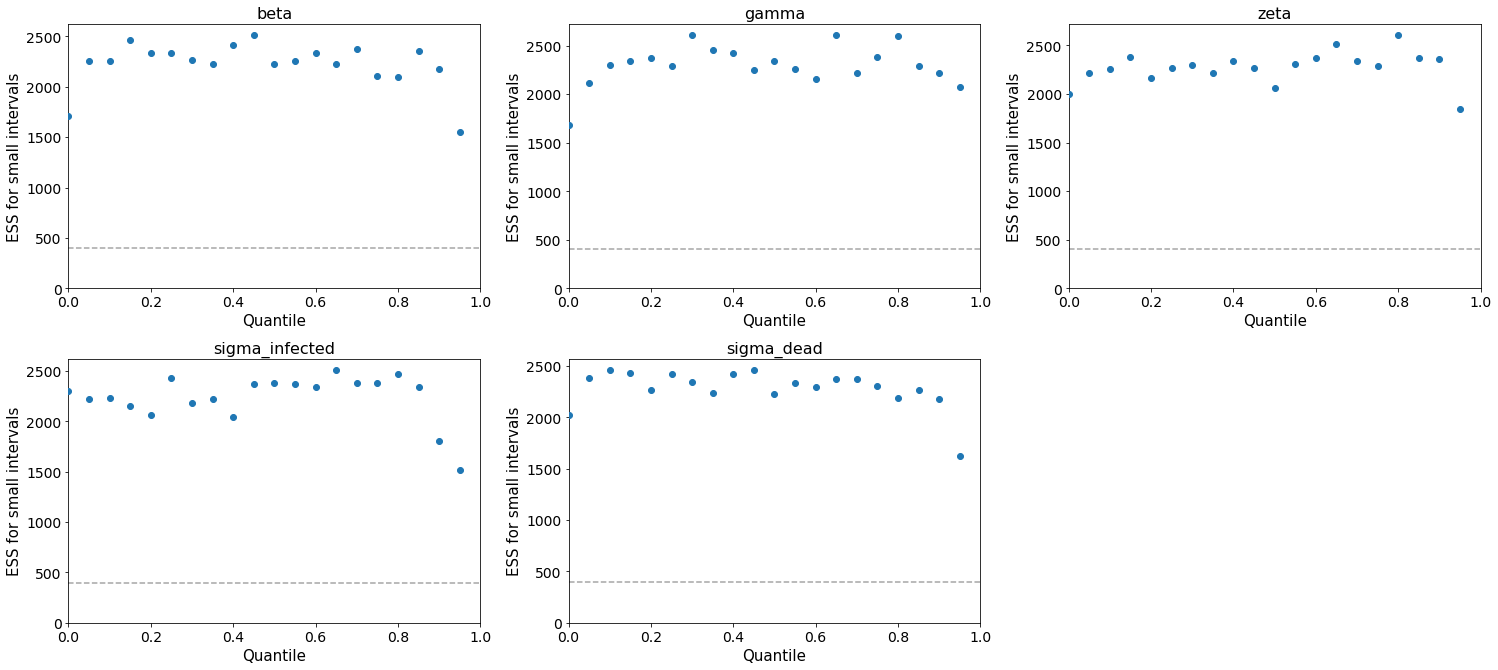

In [43]:
_ = az.plot_ess(inferred, var_names=analysis_variables)

### Leave-one-out analysis

Let's use the prepacked LOO analysis from Stan, provided here by arviz.

Computed from 2400 by 66 log-likelihood matrix

         Estimate       SE
elpd_loo  -242.57    18.30
p_loo        3.85        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       66  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



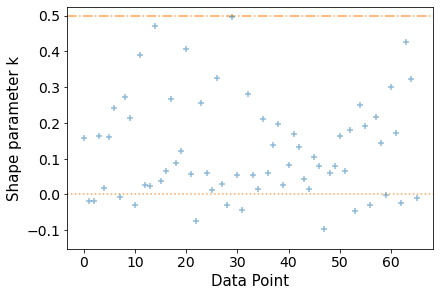

In [44]:
loo = az.loo(inferred, pointwise=True)
_ = az.plot_khat(loo)
print(loo)

No idea what this standard error value means yet, but the diagnostics look OK (i.e. we didn't get any warnings about the pareto values getting out of the "ok" region).  Also, puzzlingly ~10 parameters?

In [45]:
bfmi = az.bfmi(inferred)
print(bfmi < 0.5)

[False False False False False False]


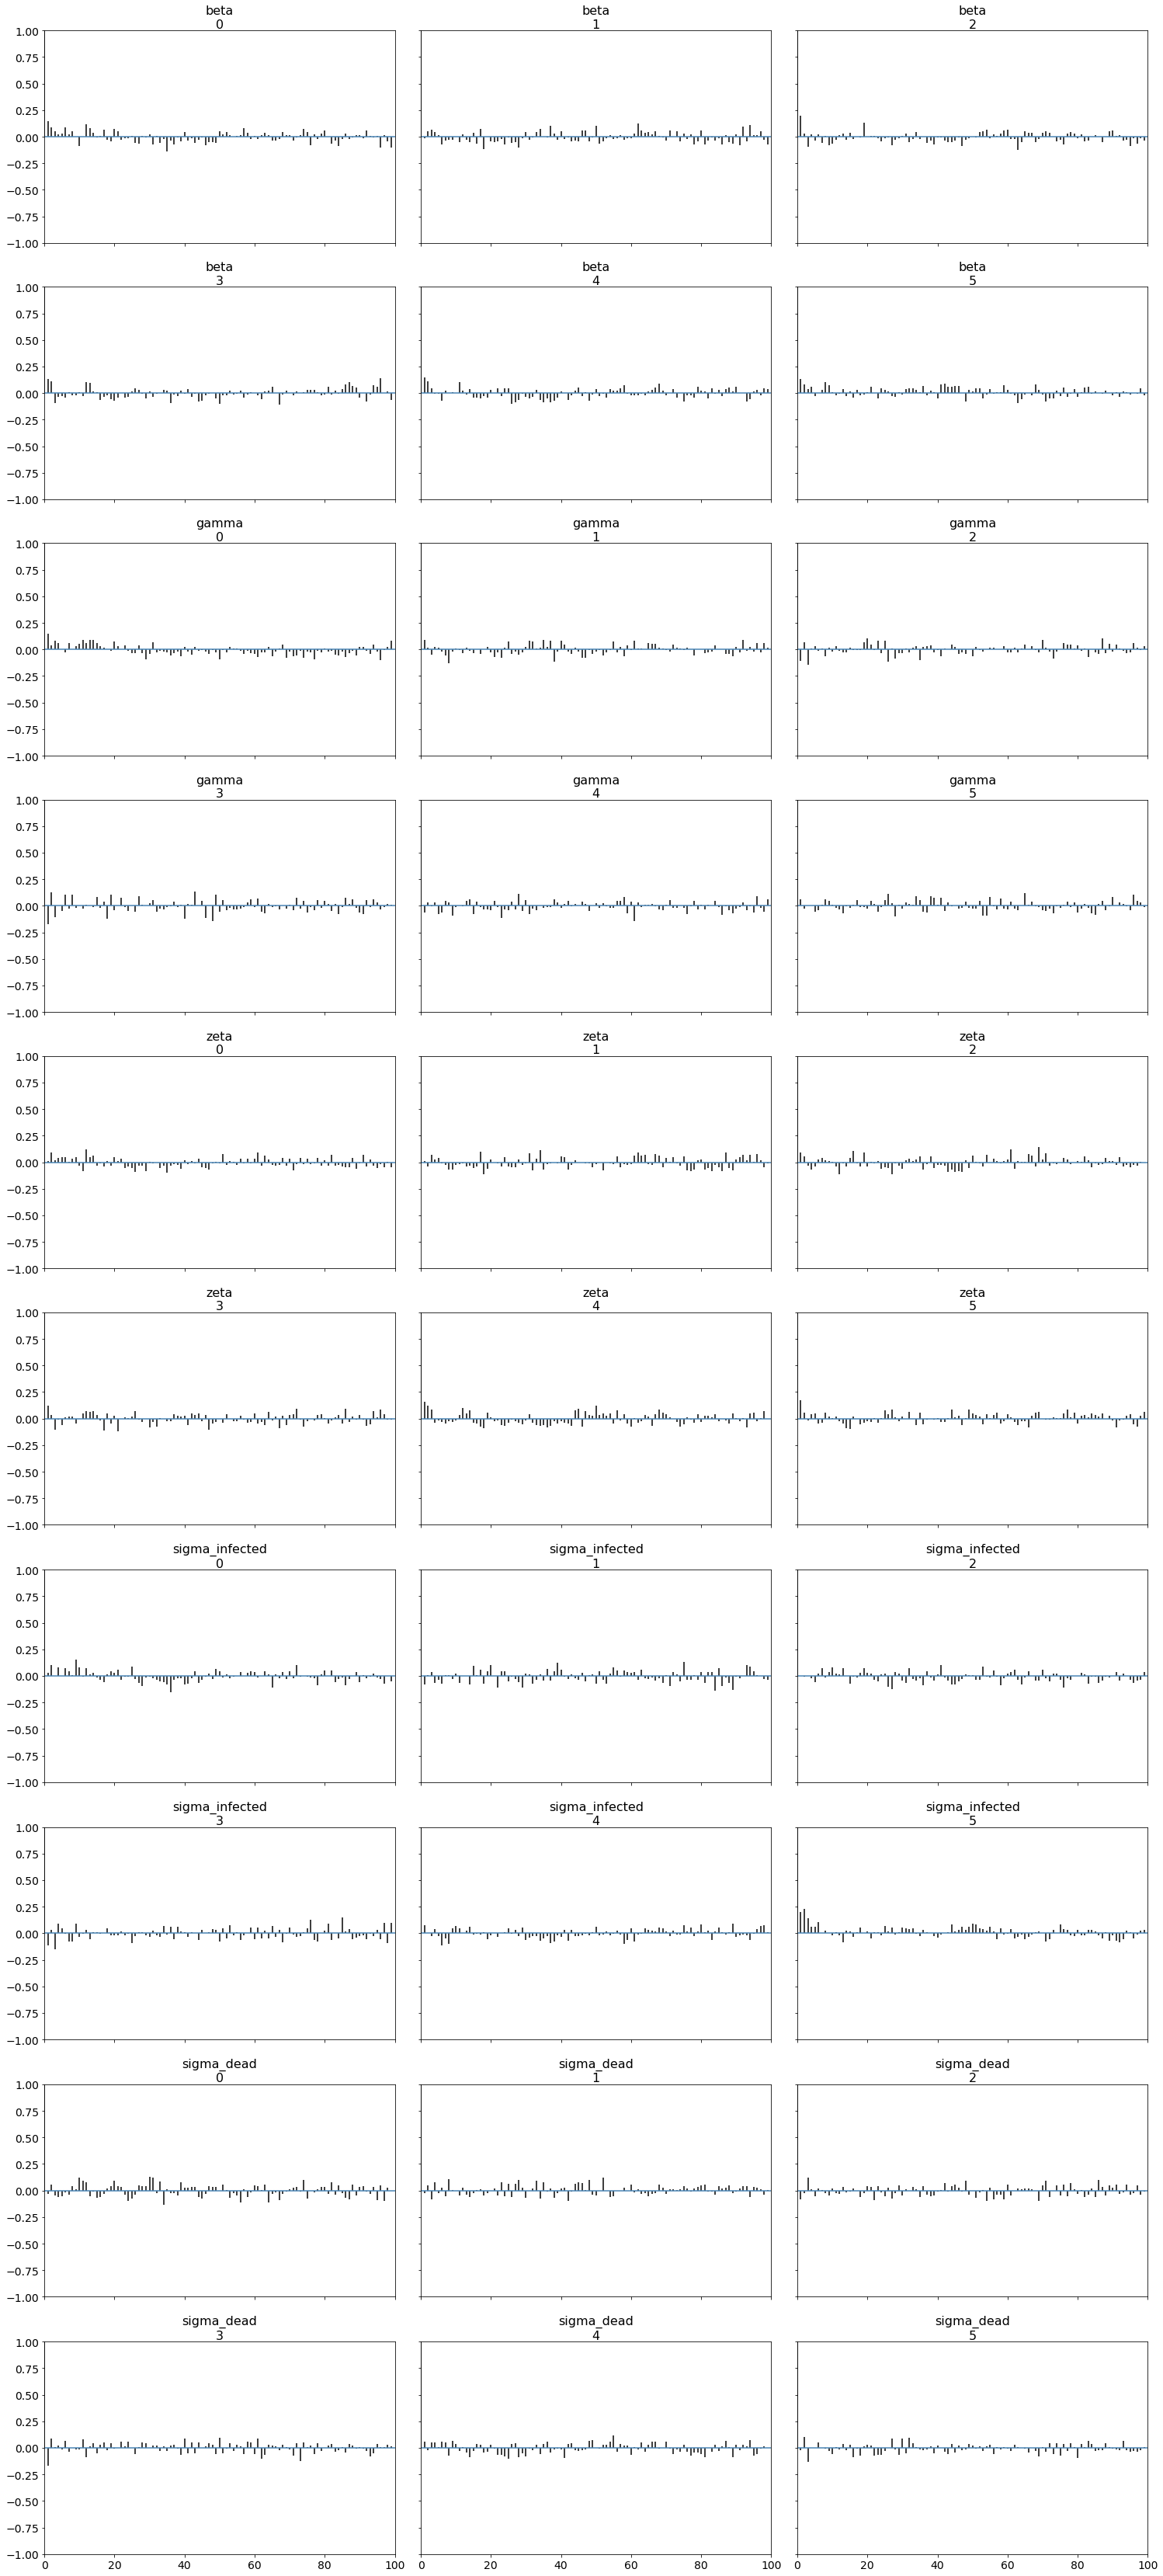

In [46]:
_ = az.plot_autocorr(inferred, var_names=analysis_variables)

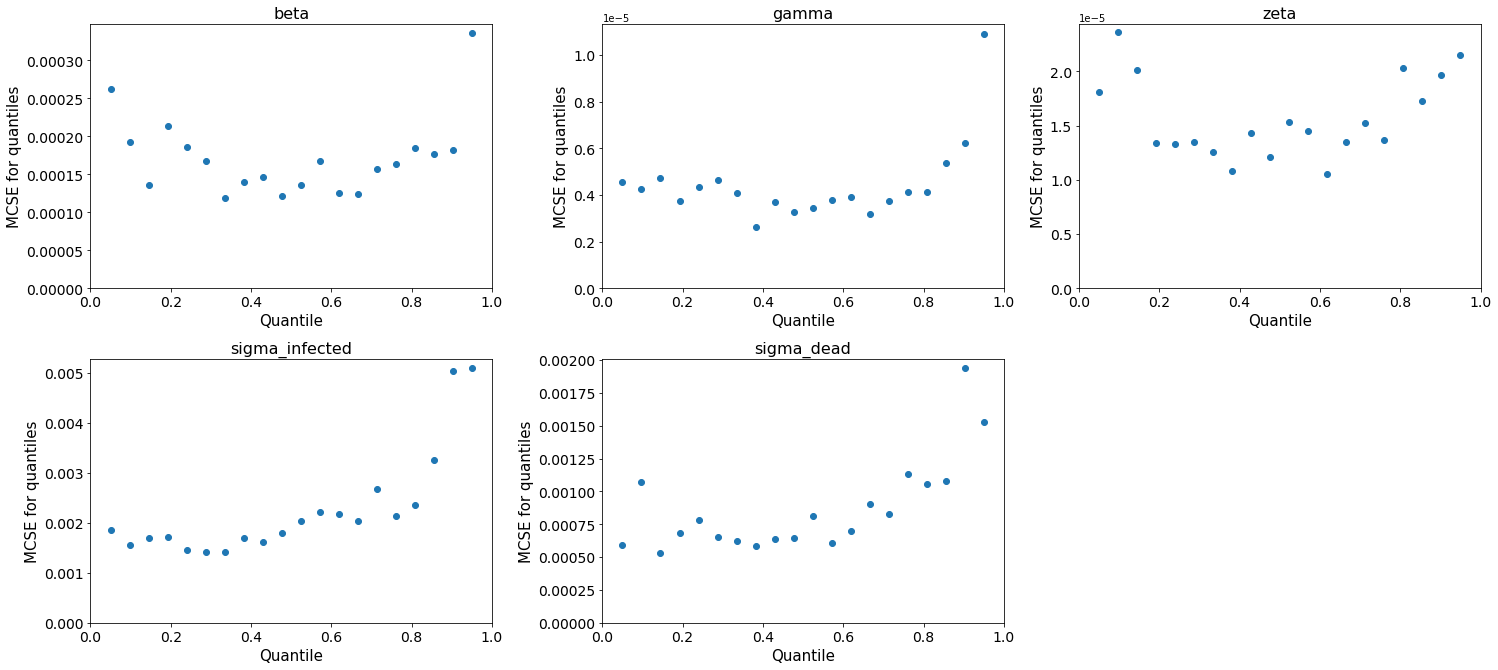

In [47]:
_ = az.plot_mcse(inferred, var_names=analysis_variables)

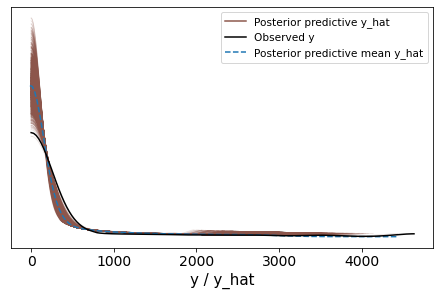

In [48]:
_ = az.plot_ppc(inferred, data_pairs={'y':'y_hat'})

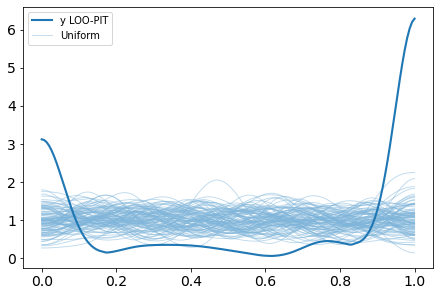

In [49]:
_ = az.plot_loo_pit(inferred, y='y', y_hat='y_hat')
loo_pit = az.loo_pit(inferred, y='y', y_hat='y_hat')